# Introduction

1. I will introduce the calculation of the molecular energy based on the different python library.
2. I will also generate my own calculations for the comparision

# Import

In [1]:
import numpy as np
import scipy
from collections import OrderedDict
from typing import List
import matplotlib.pyplot as plt

import cirq
import pyscf
import openfermion
import openfermionpyscf 
import itertools

from pyscf import gto, scf, fci
from openfermion.transforms import jordan_wigner, get_fermion_operator
from openfermionpyscf import run_pyscf
from openfermion.utils import count_qubits
from openfermion.linalg import jw_hartree_fock_state
from openfermion.circuits import simulate_trotter
from openfermion import (
    MolecularData, get_sparse_operator, get_ground_state, FermionOperator,
    jw_get_ground_state_at_particle_number,
    expectation, uccsd_convert_amplitude_format,
    get_interaction_operator, QubitOperator, eigenspectrum,
    InteractionOperator
)

# Ground energy

1. The energy unit used for computational chemical regime is Hatree (symbol: $E_{\mathrm{h}}$ or Ha). The [relationship](https://en.wikipedia.org/wiki/Hartree) to other physical units
    $$
    \begin{aligned}
    E_{\mathrm{h}} &=\frac{\hbar^{2}}{m_{\mathrm{e}} a_{0}^{2}}=m_{\mathrm{e}}\left(\frac{e^{2}}{4 \pi \varepsilon_{0} \hbar}\right)^{2}=m_{\mathrm{e}} c^{2} \alpha^{2}=\frac{\hbar c \alpha}{a_{0}} \\
    &=2 \mathrm{Ry}=2 R_{\infty} h c \\
    & \triangleq 27.211386245988(53) \mathrm{eV} \\
    & \triangleq 4.3597447222071(85) \times 10^{-18} \mathrm{~J} \\
    & \triangleq 4.3597447222071(85) \times 10^{-11} \mathrm{erg} \\
    & \triangleq 2625.4996394799(50) \mathrm{kJ} / \mathrm{mol} \\
    & \triangleq 627.5094740631(12) \mathrm{kcal} / \mathrm{mol} \\
    & \triangleq 219474.63136320(43) \mathrm{cm}{ }^{-1} \\
    & \triangleq 6579.683920502(13) \mathrm{THz} \\
    & \triangleq 315775.02480407(61) \mathrm{K}
    \end{aligned}
    $$
2. Chemical accuracy: the chemical rates is given as:
        $$
        \text { rate } \propto \frac{e^{-\beta \Delta G^{\ddagger}}}{\beta}\propto \frac{e^{- \Delta G^{\ddagger} /(RT)}}{\beta}
        $$
        where R = 1.987 cal/(K mol). an error $\epsilon$ in $\Delta G^{\ddagger}$ of 1.4 kcal/mol translate to a chemical rate error of a factor of 10. This leads to the definition of chemical accuracy which sets $\epsilon$ to the order of 1 kcal/mol.
3. The chemical accuracy given in the Hatree energy unit is given as $1/627.51 = 1.5936 \times 10^{-3}$。
   

In [2]:
CHEMICAL_ACCURACY = 1.5936e-3

In [3]:
HeH_ground_energy = OrderedDict()

In [4]:
def relative_energy_error(ground_energy: dict):
    """
    Calculate the relative energy error compare to the exact result from openfermion FCI method.
    So the FCI result should be contained.

    Args:
        ground_energy (dict): (key, value) pairs are (method, energy) pairs

    """
    # Calculate the relative energy error
    methods = list(ground_energy.keys().__reversed__())  # Output the new added one in the front
    E0 = np.array(list(ground_energy.values().__reversed__()))
    try:
        E_fci = [ground_energy[key] for key in methods if 'FCI' in key][0]
    except KeyError:
        print("No FCI method specified")
    error = E0 - E_fci
    relative_error = error / E_fci
    relative_accuracy = error/CHEMICAL_ACCURACY * 100
    # format the output data
    number = len(E0)
    print("Calculated energy from different methods:")
    vol = 25
    print("|" + "="*vol*(number+1) + "|")
    methods_row = "|" + "method".center(vol)
    for name in methods:
        methods_row += "|"
        methods_row += name.center(vol-1)
    print(methods_row + "|")
    print("|" + "-"*vol*(number+1) + "|")
    energy_row = "|" + "Energy [Hatree]".center(vol)
    for energy in E0:
        energy_row += "|"
        energy_row += f"{energy.round(20)}".center(vol-1)
    print(energy_row + "|")
    print("|" + "-"*vol*(number+1) + "|")
    er_row = "|" + "relative_error".center(vol)
    for er_r in relative_error:
        er_row += "|"
        er_row += f"{er_r.round(10)}".center(vol-1)
    print(er_row + "|") 
    print("|" + "-"*vol*(number+1) + "|")
    era_row = "|" + "relative_accuracy [%]".center(vol)
    for era_r in relative_accuracy:
        era_row += "|"
        era_row += f"{era_r.round(5)}".center(vol-1)
    print(era_row + "|") 
    print("|" + "="*vol*(number+1) + "|")
    


# openfermion

## Molecular definition


*STO* in *STO-3G* stands for *Slater type orbitals*, which means that we're using as molecular orbitals (wavefunctions of a many-particle system) anti-symmetrized products of atomic orbitals (wavefunctions of the individual particles). *3G* means thate we're approximating each Slater determinant by three Gaussian orbitals.


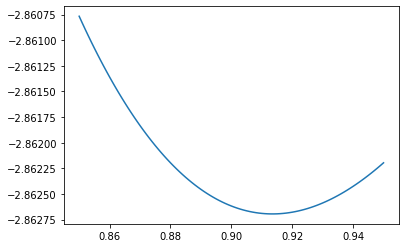

In [5]:
# Calculate the minimum energy according to the different bond lengths

# HeH+
r_list = np.linspace(0.85, 0.95, 101)
FCI_list =[]
for r in r_list:
    geometry = [['He',[0,0,0]],['H',[0,0,r]]]
    basis = 'sto-3g'  # Slater type orbital - approximated by 3 Gaussian orbital for each Slater determinant.
    multiplicity = 1  # spin multiplicity
    charge = +1
    helonium = MolecularData(geometry, basis, multiplicity, charge)
    molecule = helonium
    helonium_of = run_pyscf(helonium, run_fci = True)
    FCI_list.append(helonium_of.fci_energy)
plt.plot(r_list, FCI_list)


In [6]:
HeH_bond_length = round(r_list[np.argmin(FCI_list)], 5)
print(f"Minimum energy of the molecule bond length is {HeH_bond_length}")

Minimum energy of the molecule bond length is 0.914


In [7]:
# HeH+
r = HeH_bond_length # interatomic distance in angstrom
geometry = [['He',[0,0,0]],['H',[0,0,r]]]
basis = 'sto-3g'  # Slater type orbital - approximated by 3 Gaussian orbital for each Slater determinant.
multiplicity = 1 # spin multiplicity, 1 for spin singlet state of two electrons
charge = +1 # indicate two electrons
helonium = MolecularData(geometry, basis, multiplicity, charge)
molecule = helonium

## ground energy

In [8]:
helonium_of = run_pyscf(helonium, run_fci = True, run_cisd=True, run_ccsd = True, run_mp2=True)


In [9]:
HeH_ground_energy['openfermion.FCI'] =helonium_of.fci_energy
HeH_ground_energy['openfermion.CISD'] =helonium_of.cisd_energy
HeH_ground_energy['openfermion.mp2_energy'] =helonium_of.mp2_energy
HeH_ground_energy['openfermion.CCSD'] =helonium_of.ccsd_energy
HeH_ground_energy['openfermion.hf_energy'] =helonium_of.hf_energy
relative_energy_error(HeH_ground_energy)

Calculated energy from different methods:
|======================================================================================================================================================|
|          method         | openfermion.hf_energy  |    openfermion.CCSD    | openfermion.mp2_energy |    openfermion.CISD    |    openfermion.FCI     |
|------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Energy [Hatree]     |  -2.8542821676730235   |  -2.8626947243046503   |  -2.8607985461595513   |  -2.8626947737981916   |  -2.8626947737981903   |
|------------------------------------------------------------------------------------------------------------------------------------------------------|
|      relative_error     |     -0.0029387017      |       -1.73e-08        |     -0.0006623925      |          0.0           |          -0.0          |
|---------------------------------------

# PySCF

## Molecular definition

In [10]:
# HeH+
r = HeH_bond_length # interatomic distance in angstrom
geometry = [['He',[0,0,0]],['H',[0,0,r]]]
basis = 'sto-3g'  # Slater type orbital - approximated by 3 Gaussian orbital for each Slater determinant.
multiplicity = 1  # spin multiplicity
charge = +1
helonium_pyscf = gto.M(atom = geometry, charge = charge, basis = basis,verbose = 0)

## ground energy

In [11]:
# Get the energy from PySCF
hf_pyscf = scf.RHF(helonium_pyscf)
HeH_ground_energy['pyscf.RHF'] =hf_pyscf.kernel()

relative_energy_error(HeH_ground_energy)

Calculated energy from different methods:
|===============================================================================================================================================================================|
|          method         |       pyscf.RHF        | openfermion.hf_energy  |    openfermion.CCSD    | openfermion.mp2_energy |    openfermion.CISD    |    openfermion.FCI     |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Energy [Hatree]     |  -2.8542821676730235   |  -2.8542821676730235   |  -2.8626947243046503   |  -2.8607985461595513   |  -2.8626947737981916   |  -2.8626947737981903   |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|      relative_error     |     -0.0029387017      |     -0.00293870

In [12]:
hf_pyscf.converged

True

In [13]:
# Get Fock matrix F*C=C*e
hf_pyscf.get_fock()

array([[-1.49461571, -0.86059479],
       [-0.86059479, -0.70944457]])

# Bare methods

1. Here we ignore the specific algorithm used for search the ground energy. We just show that how those energies are calculated from the Hamiltonian and the states

## Hamiltonian

### Openfermion

1. Hamiltonian from molecule.get_molecular_hamiltonian() is an instance of InteractionOperator.
   1. Consist only of one-body and two body terms
   2. Consist only of terms that preserve particle number and spin

In [14]:
Hamiltonian = molecule.get_molecular_hamiltonian()
type(Hamiltonian)

openfermion.ops.representations.interaction_operator.InteractionOperator

The data structure consists of:
- A constant term (attribute **constant**). It represent the nuclear_repulsion.
- An NxN array of floats (matrix) representing the one body terms (attribute **one_body_tensor**). The term ((i, m)(j, n)), where 0 <= i, j < N and m,n = 0 or 1, represent the fermionic operators. For example, ((2, 1)(1, 0)) -> $a_2^\dag a_1$
- An NxNxNxN array of floats representing the two body terms (attribute **two_body_tensor**)

Where N is the number of qubits necessary to represent the molecule, that corresponds to the number of fermionic modes, or spin orbitals, that we choose to consider active.

As an example, if term $h_{p, q, r, s} a^\dagger_p a^\dagger_q a_r a_s$ occurs in *hamiltonian*, then *hamiltonian.two_body_tensor* [p,q,r,s] = $h_{p,q,r,s}$.

Since each term is particle number conserving, it must have as many creation operators as annihilation operators. So it's enough to decide a specific order for them to make the tensors non-ambiguous. The convention is *normal ordering* them. This corresponts to putting all creation operators to the left.

In [15]:
print("Constant:\n",Hamiltonian.constant)
print("Shape of One Body Tensor:\n",Hamiltonian.one_body_tensor.shape)
print("Shape of Two Body Tensor:\n",Hamiltonian.two_body_tensor.shape)

Constant:
 1.1579370042013128
Shape of One Body Tensor:
 (4, 4)
Shape of Two Body Tensor:
 (4, 4, 4, 4)


#### Jordan Winger transformation

It is necessary to represent the problem in a way that allows solving it with a quantum computer. Fermionic states will have to be mapped into qubit states, and fermionic operators will have to be mapped into qubit operators.

For example, it is necessary to transform the Hamiltonian into one that acts on the qubits that represent the fermionic state.

This is achieved by performing the **Jordan Wigner** transformation, which maps a **FermionOperator** into a **QubitOperator**. The **QubitOperator** is represented by multiple Pauli operators.



In [16]:
# One could accomplish this very easily by first mapping to fermions and
# then mapping to qubits. We skip the middle step for the sake of speed.
# qubit_Hamiltonian = jordan_wigner(Hamiltonian)
qubit_Hamiltonian = jordan_wigner(get_fermion_operator(Hamiltonian)) 

# Eliminate terms that are negligible up to a certain tolerance
qubit_Hamiltonian.compress()
type(qubit_Hamiltonian)

openfermion.ops.operators.qubit_operator.QubitOperator

If we pass the qubit Hamiltonian as an argument to **count_qubits**, it will return the minimum number of qubits it acts on.  Under the Jordan Wigner transformation, each qubit represents a specific fermionic mode (spin orbital). 

The number will be the same as **molecule.n_qubits**: the number of qubits necessary to represent a state of the molecule.

>*Example*: 
In $HeH^+$, there are 4 spin orbitals: two $1s$ spatial orbitals from each atom, each with two associated spin orbitals ($\alpha$ and $\beta$ spins). 
>
>In order to represent a state of this molecule, we need four qubits: the state of each one will represent the occupation number of the corresponding spin orbital (0 or 1, given the Pauli exclusion principle).
>
>A qubit operator acting on the state has to live in the same dimension or in a lower one. As for the Hamiltonian, it necessarily involves all of the particles representing the molecule: if they didn't affect the energy, they wouldn't be in the molecule.

## Hartree Fock state

1. Orbital that belong to the same shell have the same principal quantum number. So if we have $_1H: 1s^1$ or $_2He: 1s^2$ we use one orbital ($1s$); if we have $_3Li:1s^2 2s^1$ we use 5 ($1s$, $2s$, $2p_x$, $2p_y$, $2p_z$).

In [17]:
print(f"electrons number: {molecule.n_electrons}")
print(f"orbitals number: {molecule.n_orbitals}")
print(f"qubits number for simulation: {molecule.n_qubits}")

electrons number: 2
orbitals number: 2
qubits number for simulation: 4


### Openfermion

In [18]:
# Get Hartree Fock state from Jordan-Winger transformation
hf_vector = jw_hartree_fock_state(molecule.n_electrons,molecule.n_orbitals*2) 
print(f"Hartree Fock Vector: {hf_vector}")
# This is a vector of matrix representation of direct product of Hartree Fock state |1100>.
# The Hartree Fock state of JW transformation is |1> state occupied the first n_electrons orbitals and |0> state occupied the rest of the orbitals.
# The Hartree Fock state is used as the basis to calculate the integration of the Hamiltonian of the molecule.
# A total linear combination of Hartree Fock state: {|1100>, |1010>, |1001>, |0110>, |0101>, |0011>} may give the real state of lowest ground energy, 
# which is the ground state from the UCCSD method.


Hartree Fock Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [19]:
def Ket_to_Vector(hf_ket):
    """
    Convert a Ket of HF state to a vector representation.

    Args:
        ket (list): the list representation of a Ket of a HF state. |0> = [1, 0].T, |1> = [0, 1].T.
    
    Returns:
        hf_vector (list): the vector representation of a HF state
    """

    hf_vector = [1]
    for ket in hf_ket:
        v = [1-ket, ket]
        hf_vector = np.kron(hf_vector, v)
    return hf_vector

def Vector_to_Ket(hf_vector):
    """
    Convert a vector to a list representation of a Ket.

    Args:
        hf_vector (list): the vector representation of a HF state

    Returns:
        hf_ket (list): the list representation of a Ket of a HF state
    """

    dim = len(hf_vector)
    hf_ket = []

    while dim>1:
        if any (hf_vector[i] for i in range(int(dim/2))):
            # Ket is of the form |0>|...>.  |0> = [1, 0].T
            hf_ket.append(0)
            # Get the vector representing the state of the remaining qubits.
            hf_vector = hf_vector[:int(dim/2)]
        else:
            # Ket is of the form |1>|...>. |1> = [0, 1].T
            hf_ket.append(1)
            # Get the vector representing the state of the remaining qubits.
            hf_vector = hf_vector[int(dim//2):]
        dim = dim/2
    return hf_ket

hf_ket = Vector_to_Ket(hf_vector)
hf_vector = Ket_to_Vector(hf_ket)
print(f"hf_vector = {hf_vector}, corresponding hf_ket = |{''.join([str(x) for x in hf_ket])}>.")
    


hf_vector = [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0], corresponding hf_ket = |1100>.


### Cirq

In [20]:
# Hartree Fock state preparation circuit is implemented on CIRQ as:
qubits = cirq.LineQubit.range(molecule.n_qubits)
print(f"qubits = {qubits}")
hf_state = []
for i in range(molecule.n_qubits):
    if i < molecule.n_electrons:
        hf_state.append(cirq.X(qubits[i]))  # X: |0> -> |1>
    else:
        hf_state.append(cirq.I(qubits[i]))  # I: |0> -> |0>
print(f"hfGates = {hf_state}")

qubits = [cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2), cirq.LineQubit(3)]
hfGates = [cirq.X(cirq.LineQubit(0)), cirq.X(cirq.LineQubit(1)), cirq.I(cirq.LineQubit(2)), cirq.I(cirq.LineQubit(3))]


## Ground Energy

#### Openfermion

1. openfermion.expectation(H, $\phi$) = $\langle \phi|H|\phi \rangle$

In [21]:
HeH_ground_energy['openfermion.expectation'] = np.real(openfermion.expectation(get_sparse_operator(qubit_Hamiltonian),hf_vector))
relative_energy_error(HeH_ground_energy)

Calculated energy from different methods:
|========================================================================================================================================================================================================|
|          method         |openfermion.expectation |       pyscf.RHF        | openfermion.hf_energy  |    openfermion.CCSD    | openfermion.mp2_energy |    openfermion.CISD    |    openfermion.FCI     |
|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Energy [Hatree]     |  -2.8542821676730217   |  -2.8542821676730235   |  -2.8542821676730235   |  -2.8626947243046503   |  -2.8607985461595513   |  -2.8626947737981916   |  -2.8626947737981903   |
|-------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
def openfermion_expectation(qubit_Hamiltonian, hf_vector):
    ''' 
    Calculates the energy expectation of a HF state.

    Args:
      qubit_Hamiltonian: JW transformed qubit Hamiltonian.
      hf_vector: JW transformed HF state.
    
    Returns:
      energy (float): the energy expectation value of the state.
    ''' 

    if not isinstance(hf_vector, scipy.sparse.csc_matrix):
      ket = scipy.sparse.csc_matrix(hf_vector, dtype=complex).transpose()
    else:
      ket = hf_vector
      
    bra = ket.transpose().conj()
    H = get_sparse_operator(qubit_Hamiltonian)
    energy = (bra * H * ket)[0,0].real
    
    return energy

HeH_ground_energy['my_expectation'] = openfermion_expectation(qubit_Hamiltonian, hf_vector)
relative_energy_error(HeH_ground_energy)

Calculated energy from different methods:
|=================================================================================================================================================================================================================================|
|          method         |     my_expectation     |openfermion.expectation |       pyscf.RHF        | openfermion.hf_energy  |    openfermion.CCSD    | openfermion.mp2_energy |    openfermion.CISD    |    openfermion.FCI     |
|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Energy [Hatree]     |  -2.8542821676730217   |  -2.8542821676730217   |  -2.8542821676730235   |  -2.8542821676730235   |  -2.8626947243046503   |  -2.8607985461595513   |  -2.8626947737981916   |  -2.8626947737981903   |
|---------------------------------------------